# 0) Instructions:
Please complete the workbook below. Some of the calculations are already ready to be "run". However, please read the text carefully to find questions that you should answer for credit. Remember that to answer a question in text, you click "insert", then "insert cell below", switch the input from "code" to "markdown", type your answer, and finally click the run button to set your text in stone. In a few questions, you will need to do some calculations on your own. Hint: for these calculations you can copy, paste, and modify code that is above the calculation that you need to do. You may work by yourself or in groups of 2. Please remember to put your name on top, remember to save the workbook, and remember to upload to Canvas.

Please run the code below to load the *tidyverse* set of packages, load the *rpart* package and change the default image size to 5 x 4. Please ignore the output.

In [1]:
library(tidyverse)
library(rpart)
options(repr.plot.width = 5, repr.plot.height = 4)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


# 1) Non-parametric alternative to ANOVA
In this part of lab, we will use the Kruskal-Wallis test in order to determine if there are differences in the distribution of a continous random variable between 3 or more populations. 

In the below article, the researchers wanted to determine (amoung other aims), if the percentage of cells in G2 phase was associated with the severity of prostate cancer tumors. We will answer this research question today.

O. Nativ, Y. Raz, H.Z. Winkler, Y. Hosaka, E.T. Boyle, T.M. Therneau, G.M. Farrow, R.P. Meyers, H. Zincke, and M.M Lieber.  (1988). Prognostic value of flow cytometric nuclear DNA analysis in stage C prostate carcinoma. *Surgical Forum, 39*, 685-687.

First, we will load the data and do some processing steps (which you can ignore). Basically these steps consist of converting some variables stored as numeric to categorical variables (which R calls "factors"), combining some factor levels, and removing missing data:

In [2]:
data(stagec)
stagec <- stagec[!is.na(stagec$g2) & !is.na(stagec$gleason),]
stagec$grade <- as.factor(stagec$grade)
stagec$gleason <- as.character(stagec$gleason)
stagec$gleason[stagec$gleason %in% c("3", "4")] <- "3-4"
stagec$gleason[stagec$gleason %in% c("8", "9", "10")] <- "8-10"
stagec$gleason <- as.factor(stagec$gleason)

Okay let's use the "head" function to show us the first few observations from the dataset:

In [3]:
head(stagec)

,pgtime,pgstat,age,eet,g2,grade,gleason,ploidy
1,6.1,0,64,2,10.26,2,3-4,diploid
3,5.2,1,59,2,9.99,3,7,diploid
4,3.2,1,62,2,3.57,2,3-4,diploid
5,1.9,1,64,2,22.56,4,8-10,tetraploid
6,4.8,0,69,1,6.14,3,7,diploid
9,3.7,1,73,2,11.77,3,6,diploid


For us, we will be interested in the "g2" variable (the % of cells counted that are in G2 phase) and the "gleason" variable. This variable is a scoring system for judging the appearance of cells in the prostate gland. We will want to determine if the distribution of the "g2" variable differs between different levels of the "gleason" variable. Our first step will be to determine if the data looks approximately normally distributed. Let's make a Q-Q plot now!

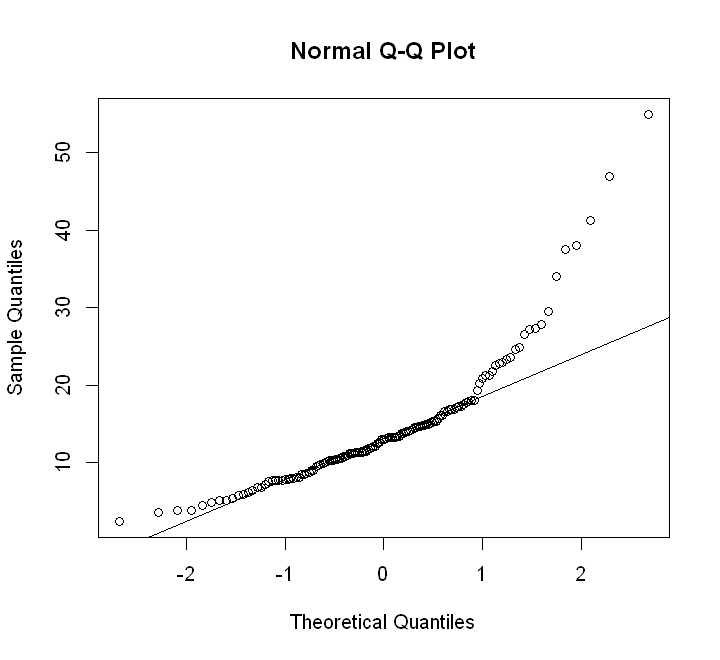

In [4]:
options(repr.plot.width = 6, repr.plot.height = 5.5)
qqnorm(stagec$g2)
qqline(stagec$g2)

**Question for you.** Based on the Q-Q plot above, do you believe that the "g2" random variable is approximately normally distributed? Please answer below in a new markdown cell.

Let's also take a look at a histogram of the same data:

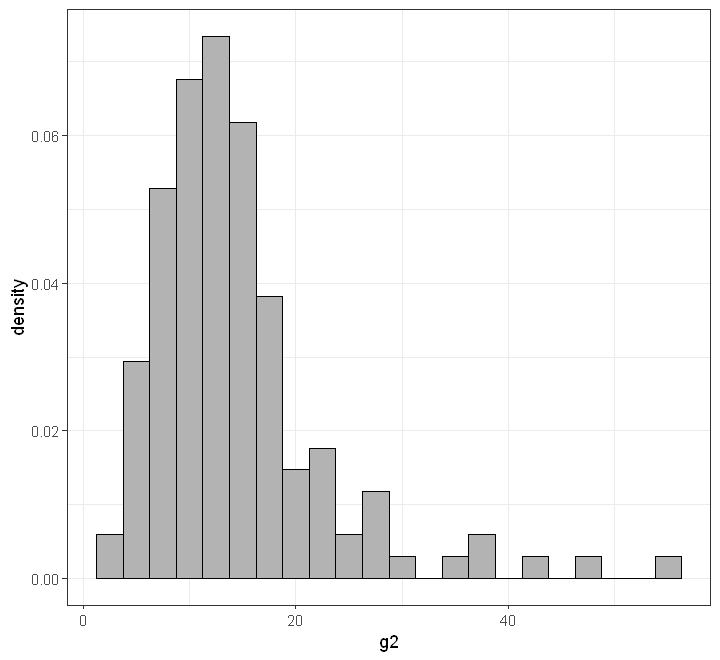

In [5]:
ggplot(stagec, aes(x = g2, y = ..density..)) + geom_histogram(color = "black", fill = "grey70", bins = 22) + theme_bw()

**Question for you.** Based on the histogram above, how would you describe the distribution of the "g2" random variable? Is there skew present? If so on which side? Is the distribution symmetric? Is it unimodal, bimodal, or multi-modal? Please answer below in a new markdown cell.

Okay, before we set up our hypotheses and statistical test, let's examine how many observations (indidual tumors) there are by the Gelason type. We can use the "table" function to do this. This tabulates the number of times a specific value occurs in a variable: 

In [6]:
table(stagec$gleason)


 3-4    5    6    7 8-10 
   8   34   33   36   25 

**Question for you**. Based on the graphical distribution of the "g2" variable you have seen thus far, do you think it is more appropriate to use parametric tests for comparing population means (like ANOVA), or non-parametric tests for comparing population distributions to answer our research question (whether the percentage of cells in G2 phase differs by Gleason category)? Please answer this question in a new markdown cell below. 

**Question for you**. Given your answer from above, please state the null and alternative hypotheses for the test that we should conduct. Rather than using fancy Greek letters, you can just write "Delta" (for example). Please write these hypotheses below in a new markdown cell. 

Let's take a final step in our exploratory analysis and produce a boxplot showing the distribution of the "g2" variable by "gleason": 

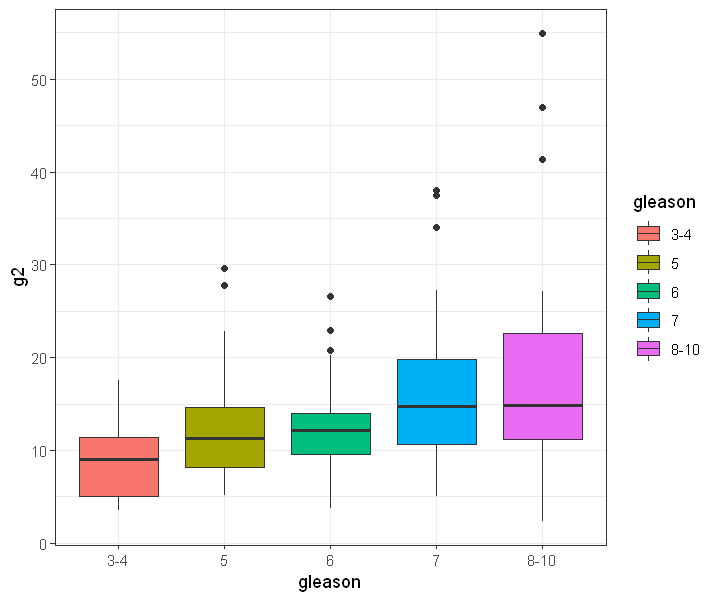

In [7]:
options(repr.plot.width = 6, repr.plot.height = 5)
ggplot(stagec, aes(x = gleason, group = gleason, y = g2, fill = gleason)) + geom_boxplot() + theme_bw()

**Question for you**. Based on the boxplot above, do you think that we will find evidence that not all of the distributions are the same? This question only requires you to guess. Please answer below with your guess in a new markdown cell. 

## 1.1) Doing the test "by hand": 
Okay, so to compute a test statistic for our Kruskal-Wallis rank sum test, we will need to combine all of the "g2" values from each group, assign ranks to each value, and then sum the ranks within each group. First let's take a look at our full set of values from the "g2" variable. To do this we will use the "\\$" notation, which retrieves a variable from a "data.frame" (in our case it will retrieve the "g2" variable from the data.frame "stagec"): 

In [8]:
stagec$g2

[1] 10.26  9.99  3.57 22.56  6.14 11.77 27.27 19.34 14.82 10.22 15.66 17.79
 [13] 11.11 11.44 14.78 54.93 24.58 27.79 14.86 10.51 14.22 15.28 16.91 17.87
 [25] 12.13 17.25 16.53 17.49  3.85  7.88 16.64 13.19  9.42 22.79 11.37  3.77
 [37] 13.76 14.52  7.55  8.46  7.66  8.40  4.43 10.37 10.82  7.81 11.23 13.99
 [49]  6.41 16.05 22.97  2.40 11.92  5.29  5.75  7.64 16.81 29.56 13.35  8.10
 [61] 12.62 14.14 10.16 17.21 11.35 11.35  7.61 20.82 12.93 21.75  8.58 14.94
 [73] 17.16 23.62 16.06  7.15 13.21 11.35  8.11 11.18 24.84  7.67 15.23  6.80
 [85] 14.58 13.17  9.76 38.05 13.87 21.20 17.96 27.14  6.74 11.21 20.22 15.35
 [97] 16.79  8.76 13.23 34.01 14.68 17.95 23.34 10.25 15.10 26.55  7.78 21.20
[109]  7.93 10.58  5.92  5.08 13.10 41.31 11.29 14.02 12.46 13.69 12.06 13.01
[121] 13.21 10.43 13.33 37.49 11.69  9.90 13.01  4.81 14.71  9.01 10.90 10.72
[133]  5.14 46.92  9.59  9.01

So now, to rank the values of this "g2" variable, we will need to determine their order. We can use the "order" function to do this. The output of this function can be a bit tricky to understand. Basically, this function will return the order in the original data that would arrange the data from smallest to largest. So below, you will find the first value is "52". This means that the smallest "g2" value comes from the 52 row in the dataset. Let's take a look below: 

In [9]:
order(stagec$g2)

[1]  52   3  36  29  43 128 112 133  54  55 111   5  49  93  84  76  39  67
 [19]  56  41  82 107  46  30 109  60  79  42  40  71  98 130 136  33 135  87
 [37] 126   2  63  10 104   1  44 122  20 110 132  45 131  13  80  94  47 115
 [55]  65  66  78  35  14 125   6  53 119  25 117  61  69 120 127 113  86  32
 [73]  77 121  99 123  59 118  37  89  48 116  62  21  38  85 101 129  15   9
 [91]  19  72 105  83  22  96  11  50  75  27  31  97  57  23  73  64  26  28
[109]  12  24 102  91   8  95  68  90 108  70   4  34  51 103  74  17  81 106
[127]  92   7  18  58 100 124  88 114 134  16

Let's now save this ordering as "newOrder":

In [10]:
newOrder <- order(stagec$g2)

Now to make use of the ordering, we will want to order our "g2" variable using this list. To do this we will use the '[]'. Let's take a quick look at how this is used. To get the first value of the "g2" variable (which is not yet ordered) we would do this: 

In [11]:
stagec$g2[1]

[1] 10.26

Or to get the fisrt through the 10th values we would do this:

In [12]:
stagec$g2[1:10]

[1] 10.26  9.99  3.57 22.56  6.14 11.77 27.27 19.34 14.82 10.22

Now to order the "g2" variable we will want to follow the same process but using our "newOrder" list:

In [14]:
stagec$g2[newOrder]

[1]  2.40  3.57  3.77  3.85  4.43  4.81  5.08  5.14  5.29  5.75  5.92  6.14
 [13]  6.41  6.74  6.80  7.15  7.55  7.61  7.64  7.66  7.67  7.78  7.81  7.88
 [25]  7.93  8.10  8.11  8.40  8.46  8.58  8.76  9.01  9.01  9.42  9.59  9.76
 [37]  9.90  9.99 10.16 10.22 10.25 10.26 10.37 10.43 10.51 10.58 10.72 10.82
 [49] 10.90 11.11 11.18 11.21 11.23 11.29 11.35 11.35 11.35 11.37 11.44 11.69
 [61] 11.77 11.92 12.06 12.13 12.46 12.62 12.93 13.01 13.01 13.10 13.17 13.19
 [73] 13.21 13.21 13.23 13.33 13.35 13.69 13.76 13.87 13.99 14.02 14.14 14.22
 [85] 14.52 14.58 14.68 14.71 14.78 14.82 14.86 14.94 15.10 15.23 15.28 15.35
 [97] 15.66 16.05 16.06 16.53 16.64 16.79 16.81 16.91 17.16 17.21 17.25 17.49
[109] 17.79 17.87 17.95 17.96 19.34 20.22 20.82 21.20 21.20 21.75 22.56 22.79
[121] 22.97 23.34 23.62 24.58 24.84 26.55 27.14 27.27 27.79 29.56 34.01 37.49
[133] 38.05 41.31 46.92 54.93

Looking at the above, you can see that we have ordered the "g2" variable from smallest to largest. However, we will later need to know not only the order of the "g2" values, but also which group they come from. So instead of just ordering the "g2" variable, we should order the entire dataset. To do this we will do the following: 

In [15]:
stagec[newOrder,]

,pgtime,pgstat,age,eet,g2,grade,gleason,ploidy
55,1.0,1,61,1,2.40,4,8-10,diploid
4,3.2,1,62,2,3.57,2,3-4,diploid
39,0.3,1,59,2,3.77,3,6,aneuploid
32,9.3,0,64,1,3.85,3,6,aneuploid
46,8.7,0,70,1,4.43,1,3-4,diploid
137,2.4,0,63,2,4.81,3,8-10,diploid
120,3.1,0,59,2,5.08,3,7,diploid
142,10.2,0,63,2,5.14,2,5,diploid
58,16.7,0,56,2,5.29,1,3-4,diploid
59,4.5,0,63,2,5.75,2,5,diploid


Okay, so above we can see how to order the data.frame by the ordering of the "g2" variable. Now let's permanantly order the observations in the data.frame; we will overwrite the "stagec" data.frame, with an ordered version of itself: 

In [16]:
stagec <- stagec[order(stagec$g2),]

Alright! Now we are ready to assign the ranks. We can do this using the "rank" function. The rank function has an argument that allows us to specify how ties are handled. We can specify 'ties.method = "average"' so that ties are handled by assigning the average rank to all of the tied observations in one tie group. 

In [21]:
rank(stagec$g2, ties.method = "average")

[1]   1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0  10.0  11.0  12.0
 [13]  13.0  14.0  15.0  16.0  17.0  18.0  19.0  20.0  21.0  22.0  23.0  24.0
 [25]  25.0  26.0  27.0  28.0  29.0  30.0  31.0  32.5  32.5  34.0  35.0  36.0
 [37]  37.0  38.0  39.0  40.0  41.0  42.0  43.0  44.0  45.0  46.0  47.0  48.0
 [49]  49.0  50.0  51.0  52.0  53.0  54.0  56.0  56.0  56.0  58.0  59.0  60.0
 [61]  61.0  62.0  63.0  64.0  65.0  66.0  67.0  68.5  68.5  70.0  71.0  72.0
 [73]  73.5  73.5  75.0  76.0  77.0  78.0  79.0  80.0  81.0  82.0  83.0  84.0
 [85]  85.0  86.0  87.0  88.0  89.0  90.0  91.0  92.0  93.0  94.0  95.0  96.0
 [97]  97.0  98.0  99.0 100.0 101.0 102.0 103.0 104.0 105.0 106.0 107.0 108.0
[109] 109.0 110.0 111.0 112.0 113.0 114.0 115.0 116.5 116.5 118.0 119.0 120.0
[121] 121.0 122.0 123.0 124.0 125.0 126.0 127.0 128.0 129.0 130.0 131.0 132.0
[133] 133.0 134.0 135.0 136.0

**Question for you**. Based on the ranks above, are there any ties present? Please answer below.

We can also check for ties using the "table" function. The idea here will be to count each time we see a specific value. Under the specific value, you will see how many times it was observed:

In [22]:
table(stagec$g2)


  2.4  3.57  3.77  3.85  4.43  4.81  5.08  5.14  5.29  5.75  5.92  6.14  6.41 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
 6.74   6.8  7.15  7.55  7.61  7.64  7.66  7.67  7.78  7.81  7.88  7.93   8.1 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
 8.11   8.4  8.46  8.58  8.76  9.01  9.42  9.59  9.76   9.9  9.99 10.16 10.22 
    1     1     1     1     1     2     1     1     1     1     1     1     1 
10.25 10.26 10.37 10.43 10.51 10.58 10.72 10.82  10.9 11.11 11.18 11.21 11.23 
    1     1     1     1     1     1     1     1     1     1     1     1     1 
11.29 11.35 11.37 11.44 11.69 11.77 11.92 12.06 12.13 12.46 12.62 12.93 13.01 
    1     3     1     1     1     1     1     1     1     1     1     1     2 
 13.1 13.17 13.19 13.21 13.23 13.33 13.35 13.69 13.76 13.87 13.99 14.02 14.14 
    1     1     1     2     1     1     1     1     1     1     1     1     1 
14.22 14.52 14.58 14.68 14.71 14.78 14.82 14.86 14.

**Question for you**. Based on the above table, how many groups of tied observations are there? Is it more than 6? Please answer below. 

Okay, let's see what we have done in creating this rank variable "G2Rank" by printing out the first few observations:

In [23]:
head(stagec)

,pgtime,pgstat,age,eet,g2,grade,gleason,ploidy,G2Rank
55,1.0,1,61,1,2.40,4,8-10,diploid,1
4,3.2,1,62,2,3.57,2,3-4,diploid,2
39,0.3,1,59,2,3.77,3,6,aneuploid,3
32,9.3,0,64,1,3.85,3,6,aneuploid,4
46,8.7,0,70,1,4.43,1,3-4,diploid,5
137,2.4,0,63,2,4.81,3,8-10,diploid,6


Okay, since there are not too many ties, we will just compute our test statistic $H$ directly. For this we need to determine the sum of ranks $T_j$ for each of the groups $j$. Below we will subset the data.frame for the observations where the Gleason category is "3-4". The "==" is a test for equivalence. So if we say 'stagec$gleason == "3-4"', we are asking R to test each observation and see if the Gleason category is "3-4", if yes the test value will be "TRUE". We then subset the data.frame for cases where this value is true: 

In [24]:
stagec[stagec$gleason == "3-4",]

,pgtime,pgstat,age,eet,g2,grade,gleason,ploidy,G2Rank
4,3.2,1,62,2,3.57,2,3-4,diploid,2
46,8.7,0,70,1,4.43,1,3-4,diploid,5
58,16.7,0,56,2,5.29,1,3-4,diploid,9
83,6.7,0,54,2,8.11,2,3-4,diploid,27
135,6.0,0,52,2,9.90,2,3-4,diploid,37
1,6.1,0,64,2,10.26,2,3-4,diploid,42
18,13.2,0,57,2,14.78,2,3-4,tetraploid,89
31,2.9,1,68,2,17.49,2,3-4,tetraploid,108


Okay, so above we see the subset of the data.frame where "gleason" is "3-4". However, we don't want the whole data.frame, we just want the "G2Rank" values for finding our $T_j$ for this group. So we can ask for just those values: 

In [25]:
stagec$G2Rank[stagec$gleason == "3-4"]

[1]   2   5   9  27  37  42  89 108

Now for $T_j$ for this group we need to sum them:

In [26]:
sum(stagec$G2Rank[stagec$gleason == "3-4"])

[1] 319

**Question for you.** Now that you have seen the process, please compute $T_j$ for the Gleason category "5". You should be able to copy, paste, and modify code from above into new code cells below. Once you have the rank sum $T_j$, please type it in a markdown cell below all of the code cells you created. 

Continuing on, we need to find $T_j^2 / n_j$ for each of the groups, as this will go into our test statistic $H$. To see the $n_j$ for each of the groups we can use the "table" function again: 

In [27]:
table(stagec$gleason)


 3-4    5    6    7 8-10 
   8   34   33   36   25 

Okay, so now, let's compute $T_j^2 / n_j$ for the group where the Gleason category is "3-4":

In [28]:
319^2 / 8

[1] 12720.12

Okay, so this has all been painful so far. However, we will use a shortcut to get the rest of the $T_j^2 / n_j$. This uses the pipping (%>%) provided by a package called *dplyr*. Basically this is a trick where we pipe things through one function to another:

In [29]:
stagec %>% group_by(gleason) %>% summarize(sumOfRanks = sum(G2Rank), n = n(), sumOfRanksSqDivn = sumOfRanks^2 / n)

gleason,sumOfRanks,n,sumOfRanksSqDivn
3-4,319,8,12720.12
5,1970,34,114144.12
6,2083,33,131481.48
7,2872,36,229121.78
8-10,2072,25,171727.36


Okay, so now we will save (as "sr") that table that we just made, as we will need it later: 

In [30]:
sr <- stagec %>% group_by(gleason) %>% summarize(sumOfRanks = sum(G2Rank), n = n(), sumOfRanksSqDivn = sumOfRanks^2 / n)

Okay, it is time to find our test statistic $H$. Here is the formula... $H = \frac{12}{N (N+1)} \sum_{j=1}^p \frac{T_j^2}{n_j} - 3(N+1)$

Okay, from our table above we determined the sample size from each group $n_j$. Let's add these all together to give us $N$: 

In [31]:
sum(sr$n)

[1] 136

Okay, now to find $\sum_{j=1}^p \frac{T_j^2}{n_j}$, we can use that same "sr" table, but now we want to sum the variable we called "sumOfRanksSqDivn": 

In [32]:
sum(sr$sumOfRanksSqDivn)

[1] 659194.9

Now we can find $H$: 

In [33]:
12 / (136 * 137) * sum(sr$sumOfRanksSqDivn) - 3 * (136 + 1)

[1] 13.55659

So we now have a test statistic.

**Question for you.** What is the sampling distribution of this test statistic if the null hypothesis is true. If you don't remember, please revisit the lecture slides. Please answer below in a new markdown cell. 

**Question for you.** Now that we remember the sampling distribution of the test statistic, let's find the critical value for a test assuming $\alpha = 0.05$. For this you can use the book tables, or use on of the functions: "qf" for quantile from an $F$ distribution, "qt" for quantiles from a $t$ distribution, "qnorm" for quantiles from a normal distribution, or "qchisq" for quantiles from a $\chi^2$ distribution. Please find this quantile below: 

**Question for you**. Now please find the p-value of this test. It is probably easiest to use one of the following functions: "pf", "pt", "pnorm", "pchisq". You will want to think about whether you want a p-value for the probability less than or equal to your test statistic ('lower.tail = TRUE'), or a p-value for the proability greater than or equal to your test statistic ('lower.tail = FALSE'):

If you forget how to use a function you can just type ?function. Try this below: 

In [ ]:
?pf

## 1.2) By software
As you might expect, it is time to do all of the work we just did in one step.

We will use the "kruskal.test" function. This function can use something called formula notation "Dependent variable ~ Independent variable" as the first argument: 

In [34]:
kruskal.test(g2 ~ gleason, data = stagec)


	Kruskal-Wallis rank sum test

data:  g2 by gleason
Kruskal-Wallis chi-squared = 13.559, df = 4, p-value = 0.008845


### 1.2.1) Pairwise comparisons
From above we can see that there is evidence that the distribution of the "g2" variable differs by "gleason". Now, if we want to determine pairs of populations differ from eachother, we can use the "pairwise.wilcoxon.test" function. This function has a few arguments; first we specify the dependent variable, second we specify the indpendent variable (the variable that says the population; and finally we can adjust the p-values to account for multiple comparisons (remember Mr. Bonferroni? He's back to save you from Type I errors). First, let's make the pairwise comparisons with no p-value adjustment:

In [35]:
pairwise.wilcox.test(stagec$g2, stagec$gleason, p.adjust.method = "none")

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"


	Pairwise comparisons using Wilcoxon rank sum test 

data:  stagec$g2 and stagec$gleason 

     3-4   5     6     7    
5    0.199 -     -     -    
6    0.118 0.506 -     -    
7    0.012 0.022 0.073 -    
8-10 0.015 0.020 0.044 0.741

P value adjustment method: none 

Now we will ask for the pairwise comparisons with the "Bonferroni" corrected p-values:

In [36]:
pairwise.wilcox.test(stagec$g2, stagec$gleason, p.adjust.method = "bonf")

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
"cannot compute exact p-value with ties"


	Pairwise comparisons using Wilcoxon rank sum test 

data:  stagec$g2 and stagec$gleason 

     3-4  5    6    7   
5    1.00 -    -    -   
6    1.00 1.00 -    -   
7    0.12 0.22 0.73 -   
8-10 0.15 0.20 0.44 1.00

P value adjustment method: bonferroni 

**Question for you**. Based on the above table of pairwise comparisons, which of the populations have different distributions? 

**Caveat** In this section we analyzed the data assuming that each Gleason score, that is 3-4, 5, 6, 7, 8-10, was a separate population. We did not treat this Gleason variable as a being orderd, but rather treated it as a nominal variable. In this case, this probably a horrible idea. We did it to illustrate the Kruskal test. It is a horrible idea because we are not recognizing that there is some order amoung the Gleason score categories. That is 3-4 < 5 < 6 < 7 < 8-10. There are other superior methods for ordinal data out there. 

# 2) Inferences regarding a single population proportion
Now, we will pivot to something very different--proportions. In this part we will determine point estimates and confidence intervals for a population proportion as well as conduct a hypothesis test for one. First, we will define some data. This data comes from the article: Sallan SE, Cronin C, Zelen M, Zinberg NE (1980), "Antiemetics in patients receiving chemotherapy for cancer: a randomized comparison of delta-9-tetrahydrocannabinol and prochlorperazine," *New England Journal of Medicine, 302*(3) p.135-138. This article evaluated the efficacy of both THC and Prochlorperaizne for the treatment of vomiting and nausea in patients undergoing chemotherapy. Below we will create the data as a matrix or table: 

In [37]:
antiemetics <- matrix(c(36, 43, 16, 62), nrow = 2, ncol = 2, byrow = TRUE)
colnames(antiemetics) <- c("Effective", "NotEffective")
rownames(antiemetics) <- c("THC", "Prochlorperazine")

This data is in a $2\times 2$ data that shows the count of study subjects in each category. Let's take a look at the data below: 

In [38]:
antiemetics

,Effective,NotEffective
THC,36,43
Prochlorperazine,16,62


## 2.1) Point estimates and confidence intervals
First, let's determine a point estimate for the propotion of chemotherapy patients for whom THC would be effective as an antiemetic. We will first save this sample proportion as "piHatTHC", and then we will view it in the cell after we save it. Remember that to compute a sample proportion we do $\hat{\pi}=y/n$:

In [41]:
piHatTHC <- 36 / (36 + 43)

In [42]:
piHatTHC

[1] 0.4556962

Now let's suppose that we would like to determine a 95% confidence interval for the population proportion of chemotherapy patients for whom THC would be effective as an antiemetic. We will determine both a Wald CI and a WAC CI. For the Wald CI remember that we need to use the following form: $\hat{\pi} \pm z_{\alpha / 2} \text{SE}(\hat{\pi})$. To determine $\text{SE}(\hat{\pi})$ we will use $\text{SE}(\hat{\pi}) = \sqrt{\frac{(\hat{\pi})(1-\hat{\pi})}{n}}$. We will first save this value as "seTHC" and then we will take a look a the value in the following cell: 

In [43]:
seTHC <- sqrt(piHatTHC * (1 - piHatTHC) / (36 + 43))

In [44]:
seTHC

[1] 0.05603312

Now for the $z_{\alpha / 2} = z_{.05/2}$, we can use the following:

In [45]:
qnorm(0.05 / 2, lower.tail = FALSE)

[1] 1.959964

We now have all of the ingredients that we need, let's put them together to find the lower endpoint for the confidence interval: 

In [46]:
piHatTHC - qnorm(0.05 / 2, lower.tail = FALSE) * seTHC

[1] 0.3458733

**Question for you**. Now please find the upper endpoint of this 95% Wald confidence interval. You can copy, paste, and modify code from above into a new code cell below to do this.

As you might expect, there is a function for that. We can use the "BinomCI" function that comes from the *DescTools* package. Since this package has been problematic for us to install, I pulled the functions that we need out of it, and placed it on my website. We can read these functions in using the "source" function. 

In [ ]:
?BinomCI

Okay, so you can see the arguments that we need are the number of successes, the number of trials, the confidence coefficient, and the method (in our case "wald"): 

In [ ]:
BinomCI(36, 36 + 43, conf.level = 0.95, method = "wald")

**Question for you.** Determine a point estimate and 95% confidence interval for the population proportion of chemotherapy patients for whom Prochlorperaizne would be effective as an antiemetic. Please determine these below in new cells.

Now to determine a 95% WAC confidence interval for the population proportion of chemotherapy patients for whom THC would be effective as an antiemetic. We will first need to find $\tilde{y}$, $\tilde{n}$, $\tilde{\pi}$, and $\text{SE}(\tilde{\pi})$.

For $\tilde{y}$, we have that $\tilde{y}=y + 0.5 \times z_{\alpha / 2}^2$:

In [ ]:
yTildeTHC <- 36 + 0.5 * qnorm(0.05 / 2, lower.tail = FALSE) ^ 2

In [ ]:
yTildeTHC

**Question for you**. Now below, please also find $\tilde{n}$. You may need to consult the lecture notes to do this. Please insert a new code cell and save $\tilde{n}$, as "nTildeTHC". 

Now we can find $\tilde{\pi}$:

In [ ]:
piTildeTHC <- yTildeTHC / nTildeTHC

In [ ]:
piTildeTHC

And now we can find $\text{SE}(\tilde{\pi})$:

In [ ]:
sePiTildeTHC <- sqrt(piTildeTHC * (1 - piTildeTHC) / nTildeTHC)

In [ ]:
sePiTildeTHC

**Question for you.** Now that you have all of the ingredients that you need for a 95% WAC confidence interval, please find the lower and upper endpoints in two separate code cells (please insert below). You should be able to repeat the same process as we used for finding Wald CI's. 

Now we can double check our work using the "BinomCI" function with the 'method = "agresti-coull"' for WAC:

In [ ]:
BinomCI(36, 36 + 43, conf.level = 0.95, method = "agresti-coull")

## 3.2) Hypothesis testing
Now we will discuss hypothesis tests regardin the value of one population parameter. Let's say that we have the following research question, "Is the population proportion of chemotherapy patients for whom THC would be effective as an antiemetic higher than 0.30 or 30%".

**Question for you**. Below in a new markdown cell please state what the null and alternative hypotheses would be for addressing this research question. 

Now, to determine a test statistic, we will use $z^* = \frac{\hat{\pi}-\pi_0}{\text{SE}(\pi_0)}$. So for this we will need to determine $\text{SE}(\pi_0)$. Below, please determine this quantity and save it as "seNullTHC". You can find the code for computing the standard error values above in the lab. 

So then here is our test statistic $z^*$: 

In [ ]:
zStar <- (piHatTHC - .30) / seNullTHC

In [ ]:
zStar

We can now determine the p-value as $P(Z \geq z^*)$: 

In [ ]:
pnorm(zStar, lower.tail = FALSE)

And now here comes the hypothesis test using R: 

In [ ]:
prop.test(x = 36, n = 36 + 43, p = .30, alternative = "greater", correct = FALSE)